In [25]:
import pandas as pd

# Load the dataset
file_path = 'data/lending-club-loan-fix.csv'
loan = pd.read_csv(file_path)

# Drop the "emp_title" and "address" columns
loan = loan.drop(columns=['emp_title', 'address'])

# Handle missing values
loan = loan.dropna()

In [26]:
from sklearn.preprocessing import LabelEncoder

# Encode the target variable (loan_status)
label_encoder = LabelEncoder()
loan['loan_status'] = label_encoder.fit_transform(loan['loan_status'])

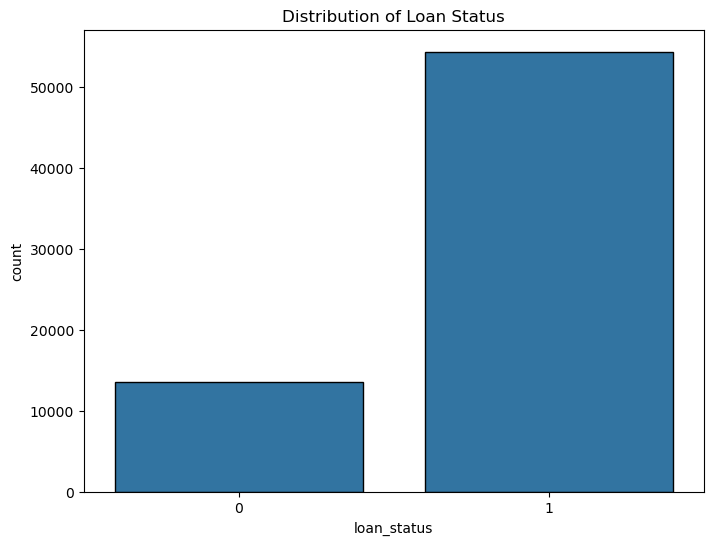

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Univariate Analysis on the Target Variable
plt.figure(figsize=(8, 6))
sns.countplot(x=y, edgecolor='black')
plt.title('Distribution of Loan Status')
plt.show()

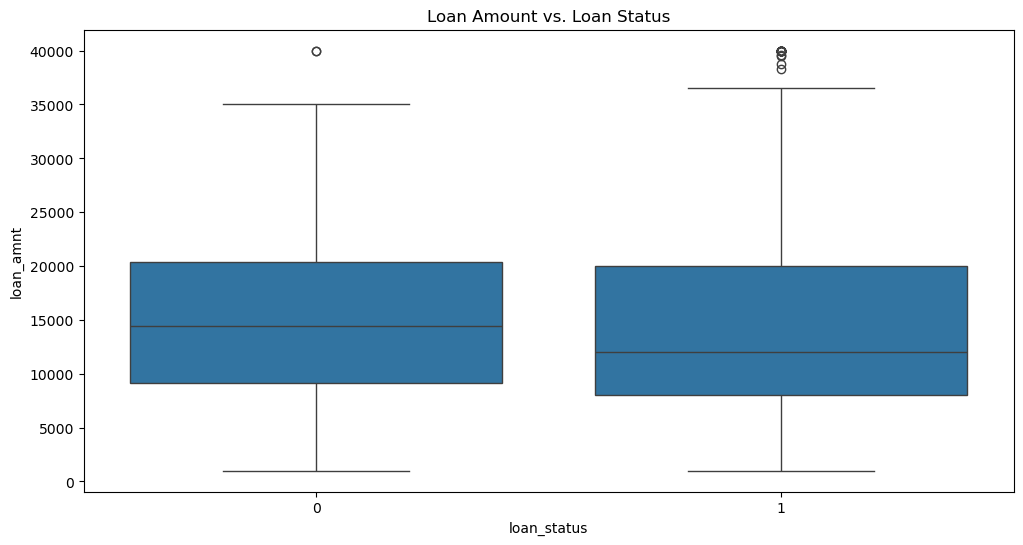

In [28]:
# Bivariate Analysis
# Relationship between loan amount and loan status
plt.figure(figsize=(12, 6))
sns.boxplot(data=loan, x='loan_status', y='loan_amnt')
plt.title('Loan Amount vs. Loan Status')
plt.show()

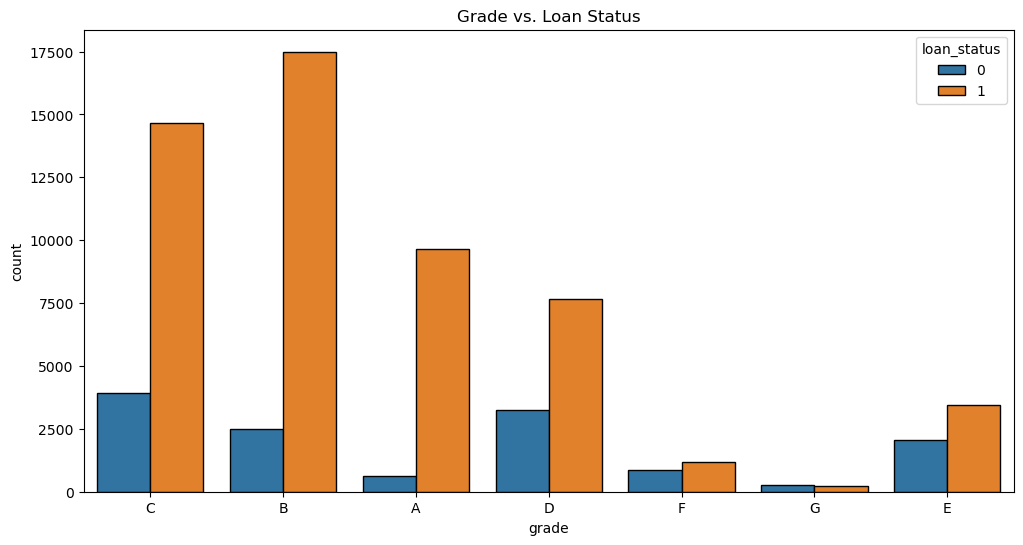

In [29]:
# Relationship between grade and loan status
plt.figure(figsize=(12, 6))
sns.countplot(data=loan, x='grade', hue='loan_status', edgecolor='black')
plt.title('Grade vs. Loan Status')
plt.show()

Non-numeric columns: Index(['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'issue_d', 'purpose', 'title',
       'earliest_cr_line', 'initial_list_status', 'application_type'],
      dtype='object')


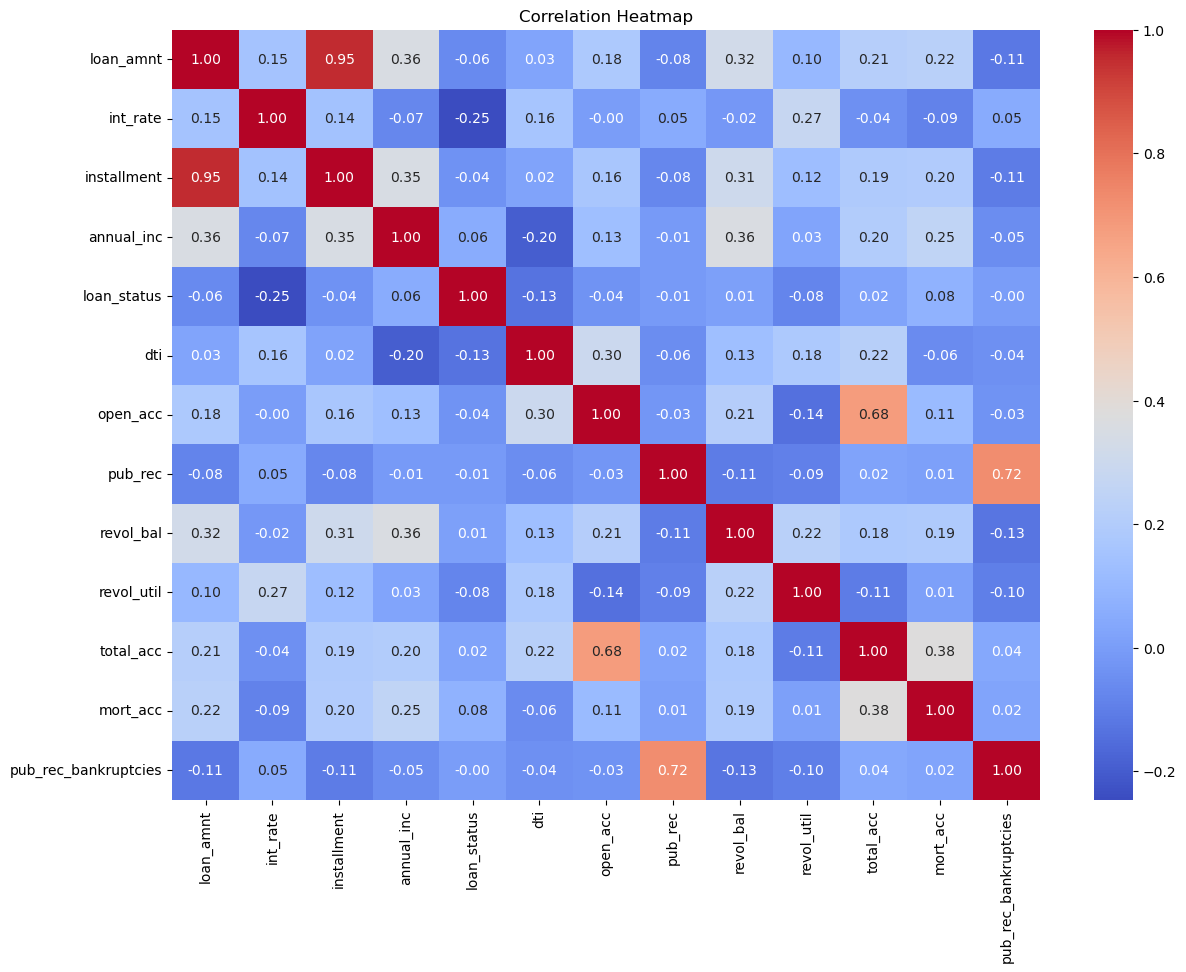

In [30]:
# Identify non-numeric columns
non_numeric_columns = loan.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_columns)

# Create a copy of the DataFrame
loan_numeric = loan.copy()

# Drop non-numeric columns from the copy
loan_numeric = loan_numeric.drop(columns=non_numeric_columns)

# Calculate the correlation matrix for numeric columns only
plt.figure(figsize=(14, 10))
sns.heatmap(loan_numeric.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

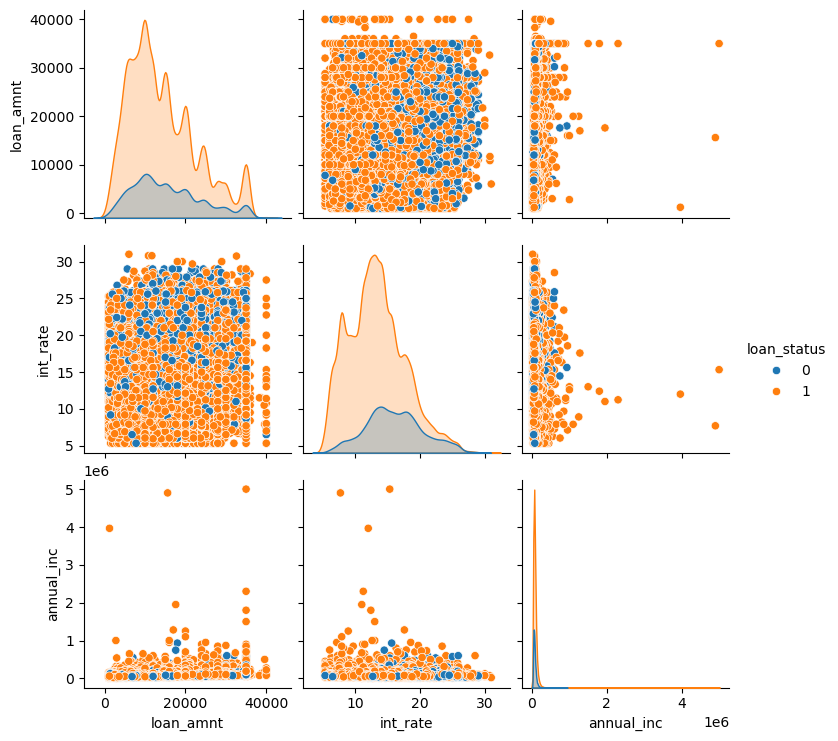

In [31]:
# Pairplot for selected features
selected_features = ['loan_amnt', 'int_rate', 'annual_inc', 'loan_status']
sns.pairplot(loan[selected_features], hue='loan_status', diag_kind='kde')
plt.show()

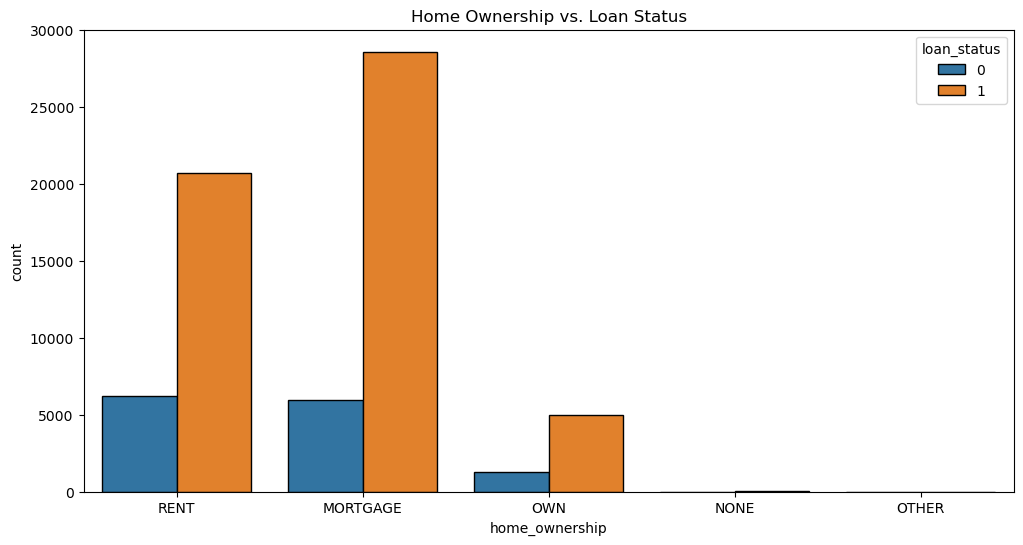

In [32]:
# Visualize Categorical Features
# Home ownership vs. loan status
plt.figure(figsize=(12, 6))
sns.countplot(data=loan, x='home_ownership', hue='loan_status', edgecolor='black')
plt.title('Home Ownership vs. Loan Status')
plt.show()

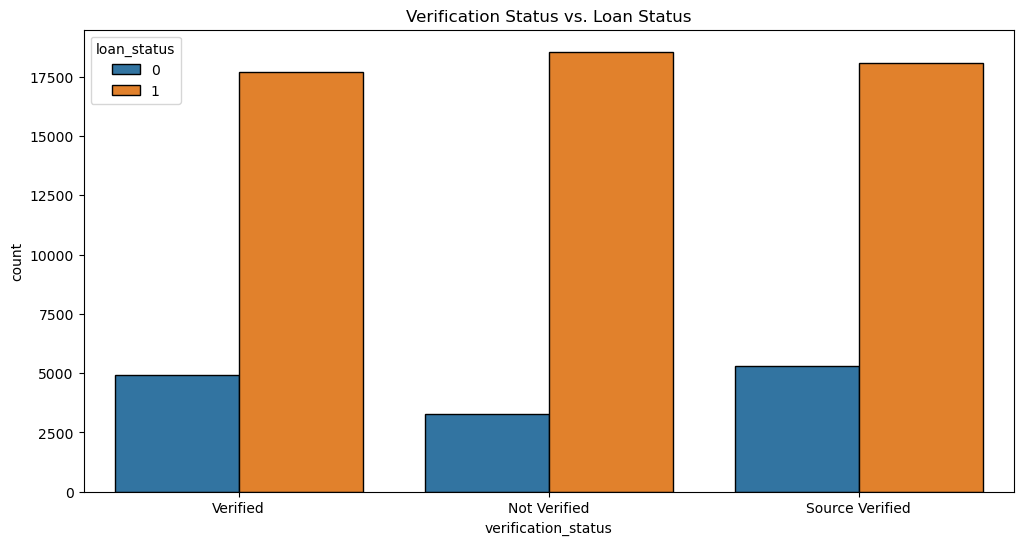

In [33]:
# Verification status vs. loan status with grid and black borders around bars
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=loan, x='verification_status', hue='loan_status', edgecolor='black')
plt.title('Verification Status vs. Loan Status')

# Add black border around the bars
for patch in ax.patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(1)

plt.show()

In [34]:
from sklearn.preprocessing import LabelEncoder

# Encode the target variable (loan_status)
label_encoder = LabelEncoder()
loan['loan_status'] = label_encoder.fit_transform(loan['loan_status'])

# Separate the target variable
y = loan['loan_status']
X = loan.drop(columns=['loan_status'])

In [35]:
# One-Hot Encoding for categorical variables with a small number of categories
one_hot_columns = [
    'term', 'grade', 'sub_grade', 'home_ownership', 
    'verification_status', 'purpose', 'initial_list_status', 'application_type'
]
X = pd.get_dummies(X, columns=one_hot_columns)

# Label Encoding for categorical variables with many unique values
label_encode_columns = ['emp_length', 'issue_d', 'title', 'earliest_cr_line']
label_encoder = LabelEncoder()
for column in label_encode_columns:
    X[column] = label_encoder.fit_transform(X[column])

In [36]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Apply SelectKBest to extract the top features
best_features = SelectKBest(score_func=f_classif, k=10)
X_selected = best_features.fit_transform(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7330483490566038
Confusion Matrix:
 [[ 629 2030]
 [1592 9317]]
Classification Report:
               precision    recall  f1-score   support

           0       0.28      0.24      0.26      2659
           1       0.82      0.85      0.84     10909

    accuracy                           0.73     13568
   macro avg       0.55      0.55      0.55     13568
weighted avg       0.72      0.73      0.72     13568



In [37]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Grid Search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the Grid Search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


In [38]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(best_model, X_selected, y, cv=5)

print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.80011792 0.80129717 0.80122347 0.80343455 0.80313974]
Mean CV Score: 0.801842570754717


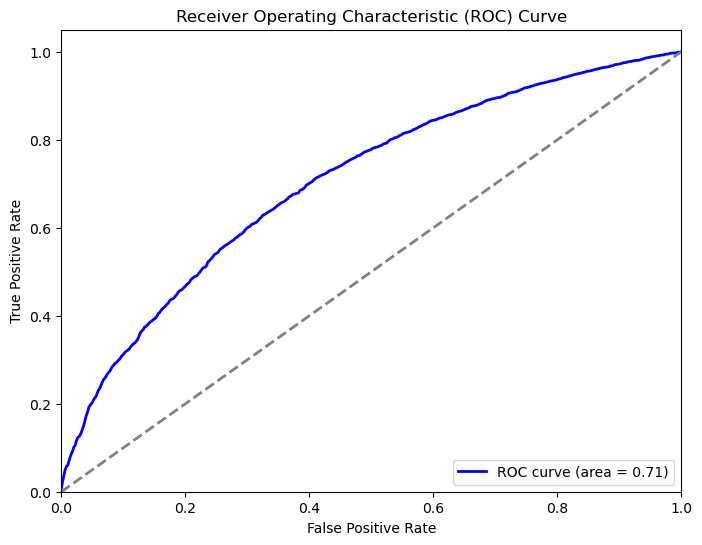

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_curve, auc
import numpy as np
from scipy import interpolate

# Get the predicted probabilities
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Interpolate the ROC curve for smoothness
fpr_interp = np.linspace(fpr.min(), fpr.max(), 500)
tpr_interp = interpolate.interp1d(fpr, tpr)(fpr_interp)

# Plot the smoothed ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_interp, tpr_interp, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

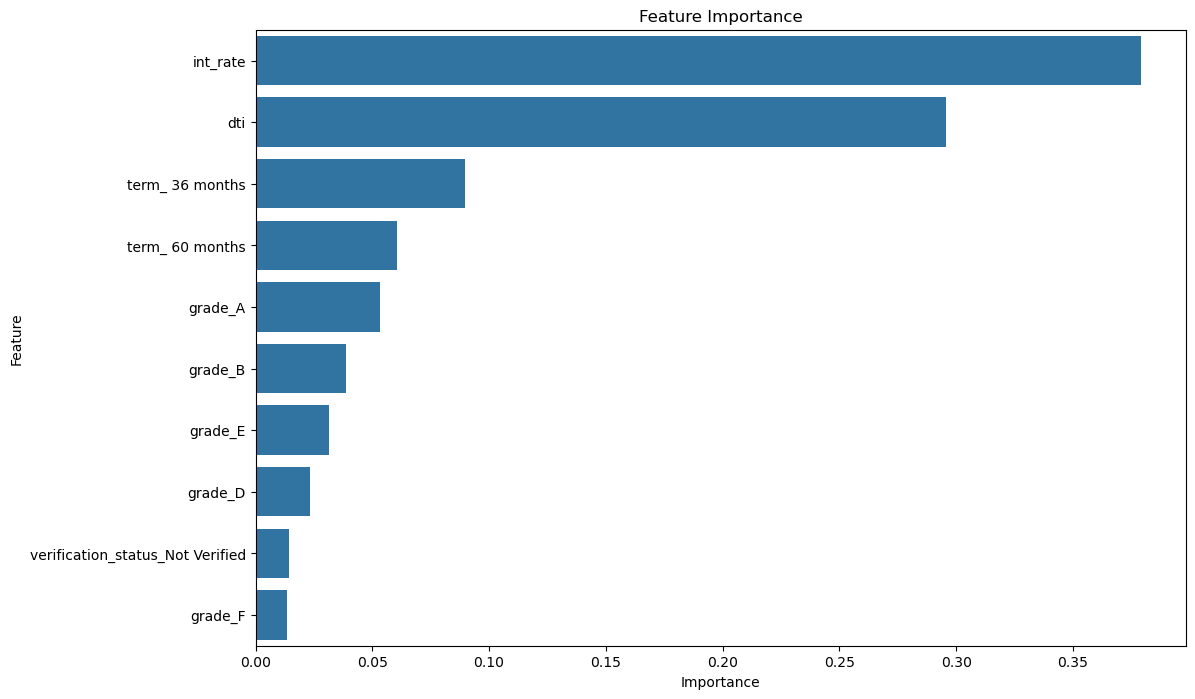

In [40]:
# Feature Importance
importances = best_model.feature_importances_
feature_importances = pd.DataFrame({'Feature': X.columns[best_features.get_support()], 'Importance': importances}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importance')
plt.show()